<a href="https://colab.research.google.com/github/Lazuardis/DESinPython/blob/main/Coffee_%26_Pizza_Eatery_Chapter_4_Optimizing_System_through_Simheuristics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Coffee & Pizza Eatery** 🍕🥤



Imagine you run a coffee & pizza eatery just around the corner of city main avenue. You want to observe how the eatery's daily operational take shape as you been told that, for some ocassion, the waiting time is too long, or some customer complaining why the tables are always occupied.

You then managed to gather some data from direct observation. Some data like processing time, customer interarrival time, until customer preference have been collected. And now using discrete event simulation, you try to actually understand how the eatery work, in a more quantitatively representative model.


In [ ]:
!pip install simpy

In [ ]:
# import the corresponding libraries

import simpy
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns



### **Last Chapter 3 Quick Recap: Simulation Replication, Validation and Data Fitting Distribution**


#### Comprehending the need of doing simulation run in replications, followed by Validation using statistical test.

---

Running simulation in replication will make the result more reliable as the variability nature of the system now are adequately encapsulated within numerous possibilities (replications). Validation then is used to make sure whether the generated output from the simulation model has been statistically representing the actual system through the implementation of hypothesis testing.

### Adjustment to the model: The need of monitoring staff and table utility

We are about to learn about system optimization. One of the associated parameter would be utility as we want our resource to have an optimal utilization.

In this chapter, we would like to introduce some minor changes to add bit complexity to the optimization itself later on. The changes see that now staff is divided into two separate task: back staff and front staff.

Back staff is responsible in preparing pizza, and front staff is responsible in preparing the coffee and doing the till job. We will encounter as well as explain this changes as we progress.

Let's get goin' to the python codes!

In [ ]:
# define the neccessary data to be involved in the simulation
# NOTE: time units interpreted across the notebook are in MINUTES

inter_arrival_time = random.expovariate(1/5) #customer arriving in every 5 minutes

processing_time = {
  "till_process": random.uniform(1,3), #till process duration is uniformly distributed from a minute through 3 minutes per customer
  "coffee_process": random.gauss(2,0.5), #coffee making process duration is normally distributed averaging one minute with 0.5 min as standard deviation
  "pizza_process": random.gauss(5,1),
  "dining_in": random.gauss(15,5)
}

**Event 1: Customer Arrival**




In [ ]:

def customer_arrival(env, inter_arrival_time):
  global customer
  global customer_served
  global waiting_customer

  customer = 0 #represent the customer ID
  while True: #while the simulation is still in condition to be run
    yield env.timeout(inter_arrival_time)
    customer += 1 #customer ID added
    customer_type = random.choices([1,2,3,4], [0.4,0.3,0.2,0.1])[0]


    next_process = till_activity(env, processing_time, customer, customer_type)
    env.process(next_process) #next process is integrated within this function


**Event 2: Till Activity**





In [ ]:
# edited with activity is performed by front staff only. Codes for Front staff utility monitoring is then added.

def till_activity(env, processing_time, customer, customer_type):
  global waiting_customer
  global front_staff_utility # Create global variable that will track the usage of front staff
  waiting_time = 0
  with front_staff.request() as till_request:
    till_wait_start = env.now
    waiting_customer += customer_type
    yield till_request
    front_staff_utility += 1 # a front staff is used, the utility is added by one
    waiting_time += env.now - till_wait_start
    waiting_customer -= customer_type
    yield env.timeout(processing_time["till_process"])
    front_staff_utility -= 1 # a front staff is released, the utility is substracted by one

  order_type = random.randint(1,3)
  dining_in = random.choices([0,1], [0.2,0.8])[0]

  order_coffee = coffee_activity(env, processing_time, customer, customer_type, dining_in, waiting_time)
  order_pizza = pizza_activity(env, processing_time, customer, customer_type, dining_in, waiting_time)
  order_all = coffee_pizza_activity(env, processing_time, customer, customer_type, dining_in, waiting_time)

  if order_type == 1:
    env.process(order_coffee)
  elif order_type == 2:
    env.process(order_pizza)
  else: env.process(order_all)

**Event 3.1: Coffee Activity**

Only proceed to this sub-event if customer order coffee only

In [ ]:
# edited with activity is performed by front staff only. Codes for Front staff utility monitoring is then added.

def coffee_activity(env, processing_time, customer, customer_type, dining_in, waiting_time):
  global customer_served
  global waiting_customer
  global customer_waiting_time
  global front_staff_utility # Confirm the variable as global variable that will track the usage of front staff
  with front_staff.request() as coffee_request:
    waiting_customer += customer_type
    order_waiting = env.now
    yield coffee_request
    front_staff_utility += 1 # a front staff is used, the utility is added by one

    yield env.timeout(processing_time["coffee_process"]*customer_type)
    waiting_customer -= customer_type
    waiting_time += env.now - order_waiting
    front_staff_utility -= 1 # a front staff is released, the utility is substracted by one


  dining_process = dining_activity(env, processing_time, customer, customer_type, waiting_time)
  if dining_in == 1:
    env.process(dining_process) #if customer intend to dine in, proceed to dine in process
  else:
    customer_served += customer_type #customer is successfully served
    customer_waiting_time.append(waiting_customer)
    # print(f"Customer {customer} leaves at {env.now:7.4f}") #if customer intend to take away, they leave


**Event 3.2: Pizza Activity**

Only proceed to this sub-event if customer order pizza only

In [ ]:
# edited with activity is performed by back staff only. Codes for back staff utility monitoring is then added.

def pizza_activity(env, processing_time, customer, customer_type, dining_in, waiting_time):
  global customer_served
  global waiting_customer
  global customer_waiting_time
  global back_staff_utility # Create global variable that will track the usage of back staff
  with back_staff.request() as pizza_request:
    waiting_customer += customer_type
    order_waiting = env.now
    yield pizza_request
    back_staff_utility += 1 # a back staff is used, the utility is added by one

    yield env.timeout(processing_time["pizza_process"]*customer_type)
    waiting_customer -= customer_type
    waiting_time += env.now - order_waiting
    back_staff_utility -= 1  # a back staff is released, the utility is substracted by one

  dining_process = dining_activity(env, processing_time, customer, customer_type, waiting_time)
  if dining_in == 1:
    env.process(dining_process) #if customer intend to dine in, proceed to dine in process
  else:
    customer_served += customer_type
    customer_waiting_time.append(waiting_customer)
    # print(f"Customer {customer} leaves at {env.now:7.4f}") #if customer intend to take away, they leave

**Event 3.3: Coffee & Pizza Activity**

Only proceed to this sub-event if customer order coffee & pizza

In [ ]:
# Both back and front staff are seized in order to perform the activity

def coffee_pizza_activity(env, processing_time, customer, customer_type, dining_in, waiting_time):
  global customer_served
  global waiting_customer
  global customer_waiting_time

  order_waiting = env.now
  waiting_customer += customer_type

  # Request both resources
  req_back_staff = back_staff.request()
  req_front_staff = front_staff.request()
  coffee_process_time = processing_time["coffee_process"]
  pizza_process_time = processing_time["pizza_process"]

  yield simpy.events.AllOf(env, [req_back_staff, req_front_staff])

  yield env.timeout(
      coffee_process_time * customer_type if coffee_process_time > pizza_process_time else pizza_process_time * customer_type)

  # code above demonstrates that the length of the process will take either one of pizza or coffee making that has the longer processing time.
  # it means that the shorter one will need to wait the other that has longer duration of making
  # this will ensure the parallel process of both pizza and coffee, and not sequential

  waiting_time += env.now - order_waiting
  waiting_customer -= customer_type

  # Release both resources
  back_staff.release(req_back_staff)
  front_staff.release(req_front_staff)


  dining_process = dining_activity(env, processing_time, customer, customer_type, waiting_time)
  if dining_in == 1:
    env.process(dining_process) #if customer intend to dine in, proceed to dine in process
  else:
    customer_served += customer_type
    customer_waiting_time.append(waiting_customer)
    # print(f"Customer {customer} leaves at {env.now:7.4f}") #if customer intend to take away, they leave

**Event 4: Dining Activity**





In [ ]:
# Integrate the variable that track seaters utilization in dining_activity function code

def dining_activity(env, processing_time, customer, customer_type, waiting_time):
  global customer_served
  global waiting_customer
  global twoseater_util
  global fourseater_util
  global customer_waiting_time
  global dissatisfied_customer


  table_waiting = env.now
  if customer_type <= 2:
    with two_seater.request() as twoseater_request:
      willingness_to_wait = random.uniform(10,25)
      waiting_customer += customer_type
      decision = yield twoseater_request | env.timeout(willingness_to_wait) # the decision is whether there is available two seater or not
      waiting_time += env.now - table_waiting
      if twoseater_request in decision:
        twoseater_util += 1
        waiting_customer -= customer_type

        yield env.timeout(processing_time["dining_in"]) # customer found two seater and dining in
        customer_served += customer_type
        twoseater_util -= 1

      else:
        customer_served += customer_type
        waiting_customer -= customer_type
        dissatisfied_customer += customer_type


  else:
    with four_seater.request() as fourseater_request:
      willingness_to_wait = random.uniform(10,25)
      waiting_customer += customer_type
      decision = yield fourseater_request | env.timeout(willingness_to_wait) # same exact scenario for group of three or four looking for four seater
      waiting_time += env.now - table_waiting
      if fourseater_request in decision:

        fourseater_util += 1
        waiting_customer -= customer_type
        yield env.timeout(processing_time["dining_in"])

        customer_served += customer_type
        fourseater_util -= 1


      else:

        customer_served += customer_type
        waiting_customer -= customer_type
        dissatisfied_customer += customer_type


  customer_waiting_time.append(waiting_time)

**Monitor Customer Function**

In [ ]:
def monitor_customer(env):
  global timestamp
  global waiting_customer_array
  timestamp = []
  waiting_customer_array = []
  while True:
    yield env.timeout(5)
    timestamp.append(env.now)
    waiting_customer_array.append(waiting_customer)

**Monitor Utilization Function**

In [ ]:
# create monitor_utilization code to track the utilization over time, same logic as monitor_customer

def monitor_utilization(env):
  global timestamp
  global twoseater_util_array
  global fourseater_util_array
  global front_staff_util_array
  global back_staff_util_array
  timestamp = []
  twoseater_util_array = []
  fourseater_util_array = []
  front_staff_util_array = []
  back_staff_util_array = []
  while True:
    yield env.timeout(2)
    timestamp.append(env.now)
    twoseater_util_array.append(twoseater_util)
    fourseater_util_array.append(fourseater_util)
    front_staff_util_array.append(front_staff_utility)
    back_staff_util_array.append(back_staff_utility)

In [ ]:
random.seed(100) #random seed to preserve same random number generated

env = simpy.Environment() #create the essential simpy environment


# define the capacity for each resource type
front_staff_cap = 2
back_staff_cap = 2
two_seater_cap = 4
four_seater_cap = 4


front_staff = simpy.Resource(env, capacity = front_staff_cap) #staff
back_staff = simpy.Resource(env, capacity = back_staff_cap) #staff
two_seater = simpy.Resource(env, capacity = two_seater_cap) #two seater for one or couple customer
four_seater = simpy.Resource(env, capacity = four_seater_cap) #four seater for three or four group of customer

customer = 0 #set the initial customer id starting from 0
customer_served = 0 #number of customer served during the start of simulation is zero
waiting_customer = 0
dissatisfied_customer = 0
twoseater_util = 0
fourseater_util = 0
front_staff_utility = 0
back_staff_utility = 0

customer_waiting_time = []


env.process(customer_arrival(env, inter_arrival_time))
env.process(monitor_customer(env))
env.process(monitor_utilization(env))
env.run(until=60*8)

print(f"Average number of customer waiting: {np.mean(waiting_customer_array):.2f}")
print(f"Average customer waiting time: {np.mean(customer_waiting_time):.2f}")
print(f"Front Staff Util: {np.mean(front_staff_util_array)/front_staff_cap:.2f}")
print(f"Back Staff Util: {np.mean(back_staff_util_array)/back_staff_cap:.2f}")
print(f"Two Seater Util: {np.mean(twoseater_util_array)/two_seater_cap:.2f}")
print(f"Four Seater Util: {np.mean(fourseater_util_array)/four_seater_cap:.2f}")

Average number of customer waiting: 38.08
Average customer waiting time: 39.56
Front Staff Util: 0.48
Back Staff Util: 0.43
Two Seater Util: 0.47
Four Seater Util: 0.19


### **Chapter 4: Optimizing System Model through Simheuristics**

Optimization has it means to tune our system model to have the best configuration in term of our desirable output parameter. Borrowing the definition of optimization in the context of operational research: *to optimize is to achieve best performance under given circumstance.*

We will talk more about this *given circumstance* later. At the moment, we are now more curious how it could be conducted. We optimize the system through simheuristics. But what is simheuristics anyway?

Simheuristics is a method that combines heuristic processes and simulation in a collaborative manner. It's a hybrid technique commonly employed in the field of simulation studies. Notably, certain DES tools, such as AnyLogic and ARENA, support simheuristic procedures.

In this context, simheuristics will be executed in a manner where the simulation runs within a heuristic design of the solution space. This approach allows the optimization process to unfold as we systematically simulate all possible solutions heuristically.

**Explore and Determine the Viable Solution Space**

Before initiating the simheuristic process, it's crucial to delineate the solution space. This refers to the range within which the heuristic program will identify solutions for performance evaluation.

Defining this space requires collaboration with decision-making authorities. For instance, in our current study, we aim to optimize the ideal staff and seater configuration. While setting values to extremes might ensure customer satisfaction, such decisions may not be practical for decision-makers. Determining the viable solution space elucidates the options that decision-makers would still consider feasible actions.

In this specific case, stakeholders expressed their willingness to increase the number of both front and back staff to a maximum of four individuals. Additionally, they noted the possibility of renting extra seating, allowing for up to six two-seaters and four four-seaters.

Each solution is represented by a combination of back staff, front staff, two-seaters, and four-seaters. For instance, a possible solution could involve two back staff, two front staff, one two-seater, and one four-seater.

Considering all possible combinations based on the stakeholder's preferences results in a total of 384 potential solutions.

Codes above resulting in system's utilization is one example of a solution performance, run in one replication.  


\

**Define the Objective Function**

Moving forward, the question arises: how do we determine the superiority of one solution over another? What criteria define the performance of a solution? The answer to this lies in the formulation of the objective function.

In operational research, the objective function in an optimization endeavor dictates whether we aim to minimize or maximize a specific variable. This could involve minimizing costs or maximizing profits, for instance.

In our specific context and study case, we've selected the average waiting time of a customer as the variable to minimize. Therefore, if a solution configuration has a lower average waiting time output parameter than the other solution, that solution is better than the other solution.

In [ ]:
import itertools

# define the possible outcome, ones that are feasible

A = {1, 2, 3, 4}
B = {1, 2, 3, 4}
C = {1, 2, 3, 4, 5, 6}
D = {1, 2, 3, 4}


# Iterate over all combinations of A, B, and C

waiting_customer_simheuristic = []
waiting_time_simheuristic = []



for a,b,c,d in itertools.product(A, B, C, D):
  avg_waiting_customer = []
  avg_waiting_time_customer = []
  for rep in range(1,100): # 100 replications
    random.seed(rep) #random seed to preserve same random number generated

    env = simpy.Environment() #create the essential simpy environment

    front_staff_cap = a
    back_staff_cap = b
    two_seater_cap = c
    four_seater_cap = d


    front_staff = simpy.Resource(env, capacity = front_staff_cap) #staff
    back_staff = simpy.Resource(env, capacity = back_staff_cap) #staff
    two_seater = simpy.Resource(env, capacity = two_seater_cap) #two seater for one or couple customer
    four_seater = simpy.Resource(env, capacity = four_seater_cap) #four seater for three or four group of customer

    customer = 0 #set the initial customer id starting from 0
    customer_served = 0 #number of customer served during the start of simulation is zero
    waiting_customer = 0
    dissatisfied_customer = 0
    twoseater_util = 0
    fourseater_util = 0
    front_staff_utility = 0
    back_staff_utility = 0

    customer_waiting_time = []


    env.process(customer_arrival(env, inter_arrival_time))
    env.process(monitor_customer(env))
    env.process(monitor_utilization(env))
    env.run(until=60*8)

    avg_waiting_customer.append(np.mean(waiting_customer_array))
    avg_waiting_time_customer.append(np.mean(customer_waiting_time))

  waiting_customer_simheuristic.append(np.mean(avg_waiting_customer))
  waiting_time_simheuristic.append(np.mean(avg_waiting_time_customer))


**How does each of the possible solution perform?**

Let's check the variable *'average customer waiting time'*

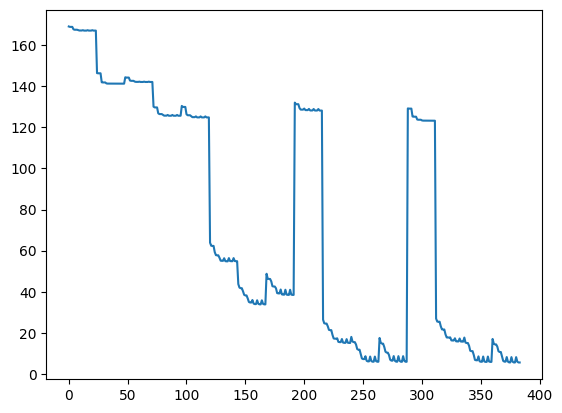

Number of total possible solution: 384


In [ ]:
plt.plot(waiting_time_simheuristic)
plt.show()

print(f"Number of total possible solution: {len(waiting_time_simheuristic)}")

**Result:**

There you go, we have seen how all 384 possible solutions are performing. Some are significantly differ to the others, while some are not necessarily. The pattern which the graph shows is normal since the heuristic procedure iterating the combination in order.  

## **Introducing the Constraints**

Constraints in optimization encapsulate certain conditions that must be met. They act as limiting factors, with some being pre-defined by system owners and others being inherent and uncontrollable.

With constraints, a model about to be optimized may encounter a massive narrow down of possible solution, as several of them might not generating variable that falls under the specified criteria.

In our case, we will introduce two constraints, is that a solution is deemed feasible to take, only when:

1.   The overall utility of front staff is no less than 40%
2.   The overall utility of back staff is no less than 30% (less than front staff to compensate their other responsibility such as cleaning the kitchen which are not modeled)

**What can we expect from these constraint?**

We can eliminate all the possible solution that are not good enough as the predefined constraint describe the minimum *'quality'* of a solution. This way, there is a chance that we are not comparing the entire 384 solutions as many of them would be *infeasible*.



In [ ]:
import itertools

A = {1, 2, 3, 4}
B = {1, 2, 3, 4}
C = {1, 2, 3, 4, 5, 6}
D = {1, 2, 3, 4}


# Iterate over all combinations of A, B, and C

waiting_customer_simheuristic = []
waiting_time_simheuristic = []
results = {}
current_best_solution = 10000000
best_solution_over_iteration = []

for a,b,c,d in itertools.product(A, B, C, D):
  avg_waiting_customer = []
  avg_waiting_time_customer = []
  front_staff_util = []
  back_staff_util = []
  for rep in range(1,100): # 100 replications
    random.seed(rep) #random seed to preserve same random number generated

    env = simpy.Environment() #create the essential simpy environment

    front_staff_cap = a
    back_staff_cap = b
    two_seater_cap = c
    four_seater_cap = d


    front_staff = simpy.Resource(env, capacity = front_staff_cap) #staff
    back_staff = simpy.Resource(env, capacity = back_staff_cap) #staff
    two_seater = simpy.Resource(env, capacity = two_seater_cap) #two seater for one or couple customer
    four_seater = simpy.Resource(env, capacity = four_seater_cap) #four seater for three or four group of customer

    customer = 0 #set the initial customer id starting from 0
    customer_served = 0 #number of customer served during the start of simulation is zero
    waiting_customer = 0
    dissatisfied_customer = 0
    twoseater_util = 0
    fourseater_util = 0
    front_staff_utility = 0
    back_staff_utility = 0

    customer_waiting_time = []


    env.process(customer_arrival(env, inter_arrival_time))
    env.process(monitor_customer(env))
    env.process(monitor_utilization(env))
    env.run(until=60*8)

    avg_waiting_customer.append(np.mean(waiting_customer_array))
    avg_waiting_time_customer.append(np.mean(customer_waiting_time))
    front_staff_util.append(np.mean(front_staff_util_array)/front_staff_cap)
    back_staff_util.append(np.mean(back_staff_util_array)/back_staff_cap)

  # we define the constraints here
  if np.mean(front_staff_util) < 0.4:
    continue # if the solution does not satisfy this constraint, skip it
  if np.mean(back_staff_util) < 0.3:
    continue # if the solution does not satisfy this constraint, skip it


  waiting_customer_simheuristic.append(np.mean(avg_waiting_customer))
  waiting_time_simheuristic.append(np.mean(avg_waiting_time_customer))
  results[(a, b, c, d)] = np.mean(avg_waiting_time_customer)

  # codes below are designate to create more intuitive graph explaining how each solution performs heuristically
  if waiting_time_simheuristic[-1] < current_best_solution:
    best_solution_over_iteration.append(waiting_time_simheuristic[-1])
    current_best_solution = waiting_time_simheuristic[-1]
  else:
    best_solution_over_iteration.append(current_best_solution)

best_combination = min(results, key=results.get)
best_solution = results[best_combination]


In [ ]:
best_combination

(2, 2, 4, 4)

meaning that the best combination is to employ two front staff, two back staff, rent 5 two-seater and 3 four-seater

In [ ]:
best_solution

54.81403987751855


The optimal solution identified here reflects an average waiting time of 54.8 minutes for a customer throughout the entire process within the eatery. When comparing this result to the earlier line graph, it appears notably higher, especially considering some solutions showed a performance of less than 20 minutes. This discrepancy underscores the impact of integrating constraints, where intuitively, excessively low performance (less than 20 minutes) may be attributed to employing too much staff, resulting in utilization performance below the minimum expected threshold, thus making it infeasible.

In the graph below, we've altered the y-axis approach. Rather than illustrating the fluctuating performance across all possible solutions through heuristic steps, we now showcase the 'best solution' after the n-th possible solution on the x-axis. This adjustment provides a clearer representation of the performance trend, focusing on the optimal solutions rather than the individual performances of each possible solution, as done earlier.

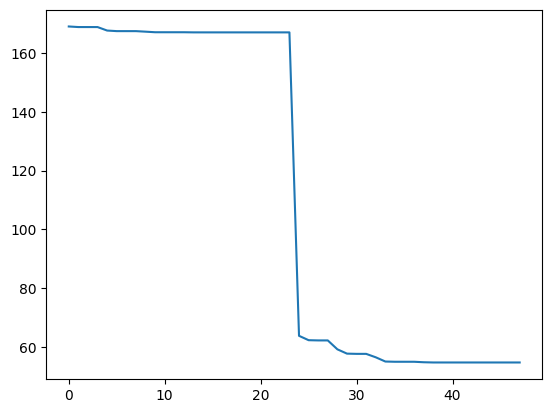

Number of total possible solution: 48


In [ ]:
plt.plot(best_solution_over_iteration)
plt.show()


print(f"Number of total possible solution: {len(best_solution_over_iteration)}")

Provided the constraint, the total possible solution is now only 48.

### What if the stakeholder more concerned about the cost?

**Preference that would change the objective function and the constraint of our optimization model**

The initial choice of using average waiting time as a constraint is reconsidered, not because it is an incorrect metric but rather due to its complexity and lack of direct emphasis.

The new preference leans toward operational expenditure. Consequently, we modify the objective function to minimize the operational expenditure arising from employee wages and the rental fees incurred for seating provision.

As for constraints, there's a shift in focus. Utilization is no longer the key metric; instead, the stakeholder prioritizes average waiting time as the constraint. The objective now is to avoid any compromise where the average customer wait time exceeds 20 minutes. This adjustment aligns with the stakeholder's revised emphasis on minimizing operational costs while ensuring an acceptable level of customer service.

In [ ]:
import itertools

A = {1, 2, 3, 4}
B = {1, 2, 3, 4}
C = {1, 2, 3, 4, 5, 6}
D = {1, 2, 3, 4}

front_staff_wage = 80
back_staff_wage = 95
two_seater_rent = 40
four_seater_rent = 70

# Iterate over all combinations of A, B, and C

waiting_customer_simheuristic = []
waiting_time_simheuristic = []
results = {}
current_best_solution = 10000000
best_solution_over_iteration = []

for a,b,c,d in itertools.product(A, B, C, D):
  avg_waiting_customer = []
  avg_waiting_time_customer = []

  for rep in range(1,100): # 100 replications
    random.seed(rep) #random seed to preserve same random number generated

    env = simpy.Environment() #create the essential simpy environment

    front_staff_cap = a
    back_staff_cap = b
    two_seater_cap = c
    four_seater_cap = d


    front_staff = simpy.Resource(env, capacity = front_staff_cap) #staff
    back_staff = simpy.Resource(env, capacity = back_staff_cap) #staff
    two_seater = simpy.Resource(env, capacity = two_seater_cap) #two seater for one or couple customer
    four_seater = simpy.Resource(env, capacity = four_seater_cap) #four seater for three or four group of customer

    customer = 0 #set the initial customer id starting from 0
    customer_served = 0 #number of customer served during the start of simulation is zero
    waiting_customer = 0
    dissatisfied_customer = 0
    twoseater_util = 0
    fourseater_util = 0
    front_staff_utility = 0
    back_staff_utility = 0

    customer_waiting_time = []


    env.process(customer_arrival(env, inter_arrival_time))
    env.process(monitor_customer(env))
    env.process(monitor_utilization(env))
    env.run(until=60*8)

    avg_waiting_customer.append(np.mean(waiting_customer_array))
    avg_waiting_time_customer.append(np.mean(customer_waiting_time))

  # we define the new constraint here
  if np.mean(avg_waiting_time_customer) > 20:
    continue # if the solution does not satisfy this constraint, skip it

  waiting_customer_simheuristic.append(np.mean(avg_waiting_customer))
  waiting_time_simheuristic.append(np.mean(avg_waiting_time_customer))
  results[(a, b, c, d)] = (a*front_staff_wage + b*back_staff_wage + c*two_seater_rent + d*four_seater_rent)

  if waiting_time_simheuristic[-1] <= current_best_solution:
    best_solution_over_iteration.append(waiting_time_simheuristic[-1])
    current_best_solution = waiting_time_simheuristic[-1]
  else:
    best_solution_over_iteration.append(current_best_solution)

best_combination = min(results, key=results.get)
best_solution = results[best_combination]


In [ ]:
best_combination

(3, 2, 3, 1)

In [ ]:
best_solution

620

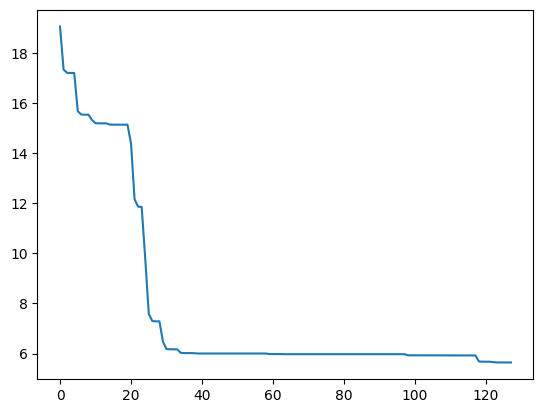

Number of total possible solution: 128


In [ ]:
plt.plot(best_solution_over_iteration)
plt.show()

print(f"Number of total possible solution: {len(best_solution_over_iteration)}")